# Comprehensive Guide To Approximate Nearest Neighbors Algorithms

## Exhaustive Search Usage

In [15]:
from annoy import AnnoyIndex
import nmslib
from pathlib import Path
import pandas as pd
import time

## recrateing movie lesne directly


### Load and Preprocess the Movie Data
You need to prepare your movie data for encoding. For example, you may want to combine the title, description, and genres to form a rich text representation of each movie.

In [2]:
# import pandas as pd

# Path to the movie metadata file
# movies_file_path = 'ml-100k/u.item'
movies_file_path = Path('./MovieLens/ml-100k/u.item')
# Define all 24 column names based on the dataset description
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + \
                [f'genre_{i}' for i in range(19)]  # 19 genre columns



# Load the data with the correct number of columns
movies = pd.read_csv(movies_file_path, sep='|', encoding='latin-1', header=None, names=movie_columns)

# Display the first few rows
print(movies.head())


   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  genre_0  genre_1  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0        1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0        0   

   genre_2  genre_3  genre_4  ...  genre_9  genre_10  genre_11  genre_12  \
0        0        1        1  ...        0         0         0         0   


In [9]:
# import pandas as pd
# import pickle

# Load the MovieLens 100K ratings data
# ratings_file_path = 'ml-100k/u.data'  # Replace with the correct path to the 'u.data' file
ratings_file_path = Path('./MovieLens/ml-100k/u.data')

# The data does not have headers in the file, so we specify them
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_file_path, sep='\t', names=columns)

# Display first few rows of the dataset
print(ratings.head())

# Save the ratings data as a pickle file
with open('movielens_100k_ratings.pickle', 'wb') as f:
    pickle.dump(ratings, f)

print("MovieLens 100K ratings data saved to movielens_100k_ratings.pickle!")


   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
MovieLens 100K ratings data saved to movielens_100k_ratings.pickle!


In [3]:
# Example: Create a text representation for each movie by combining title and genres
movies['text_representation'] = movies['title'] + ' ' + movies['release_date']

# Display the dataset with the text representation
print(movies[['movie_id', 'text_representation']].head())

   movie_id            text_representation
0         1   Toy Story (1995) 01-Jan-1995
1         2   GoldenEye (1995) 01-Jan-1995
2         3  Four Rooms (1995) 01-Jan-1995
3         4  Get Shorty (1995) 01-Jan-1995
4         5     Copycat (1995) 01-Jan-1995


### Use a Pretrained Model to Generate Embeddings
Now, we’ll use a pretrained transformer model to create semantic embeddings for the movie text data. The model will convert the text representation of each movie into a vector of fixed size, capturing its semantic meaning.

In [6]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model (e.g., 'all-MiniLM-L6-v2' is small and fast)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate semantic embeddings for the movie text representations
movie_descriptions = movies['text_representation'].tolist()
movie_embeddings = model.encode(movie_descriptions, show_progress_bar=True)

# The movie_embeddings is a matrix where each row is the vector for a movie
print(f"Shape of embeddings: {movie_embeddings.shape}")


c:\Users\Hassan\anaconda3\envs\Py39Stanford1\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Hassan\anaconda3\envs\Py39Stanford1\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hassan\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

c:\Users\Hassan\anaconda3\envs\Py39Stanford1\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Shape of embeddings: (1682, 384)


### Save the Encoded Data
You can now save these embeddings for future use (e.g., for similarity search or as input to a recommendation model). You might also want to save the movie titles along with the embeddings to keep track of which vector corresponds to which movie.

In [16]:
import pickle

# Save the movie embeddings and their corresponding titles
with open('movie_embeddings.pickle', 'wb') as f:
    pickle.dump((movies['movie_id'].tolist(), movie_embeddings), f)

print("Movie embeddings saved to 'movie_embeddings.pickle'")


Movie embeddings saved to 'movie_embeddings.pickle'


### Perform Similarity Search (Optional)
If your goal is to perform a similarity search (e.g., find similar movies based on their semantic embeddings), you can use FAISS, a library that allows efficient similarity searches over large vector spaces.

In [9]:
import faiss
import numpy as np

# Convert embeddings to a NumPy array
movie_embeddings_np = np.array(movie_embeddings)

# Create a FAISS index
index = faiss.IndexFlatL2(movie_embeddings_np.shape[1])  # L2 distance (Euclidean)
index.add(movie_embeddings_np)  # Add embeddings to the index

# Search for the 5 most similar movies to the first movie in the dataset
query_embedding = movie_embeddings_np[0].reshape(1, -1)
distances, indices = index.search(query_embedding, 5)

# Print the most similar movies
for idx in indices[0]:
    print(f"Movie ID: {movies.iloc[idx]['movie_id']}, Title: {movies.iloc[idx]['title']}")


Movie ID: 1, Title: Toy Story (1995)
Movie ID: 1219, Title: Goofy Movie, A (1995)
Movie ID: 1470, Title: Gumby: The Movie (1995)
Movie ID: 772, Title: Kids (1995)
Movie ID: 93, Title: Welcome to the Dollhouse (1995)


In [10]:
text_representation_array = np.array(movies['text_representation'])

In [203]:
# dataframe
df_NearNeigh = pd.DataFrame(columns=[ 'Query_Results', 'Index_Time', 'Search_Time'])
df_NearNeigh.index.name = "NearNeigh_Type"
df_NearNeigh

,Query_Results,Index_Time,Search_Time
NearNeigh_Type,,,


### copy paper

In [204]:
class ExactIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        # self.lab
        self.labels = labels
   
    def build(self):
        self.index = faiss.IndexFlatL2(self.dimension,)
        self.index.add(self.vectors)
        
    def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k) 
        # I expect only query on one vector thus the slice
        return [self.labels[i] for i in indices[0]]

In [205]:
start_time = time.time()
movie_desc = np.array(movies['text_representation'])
index = ExactIndex(movie_embeddings_np, movie_desc)
index.build()
end_time = time.time()
index_time = end_time - start_time
print(f'Time to build with IndexFlatL2 {end_time - start_time}')
NN_Type = 'Exhaustive'
# df_NearNeigh.loc[NN_Type] = {'Index_Time':index_time}
# df_NearNeigh


Time to build with IndexFlatL2 0.0029938220977783203


In [260]:
index.vectors.size

645888

In [206]:
# index.query(data['vector'][0])
start_time = time.time()
query_results = index.query(movie_embeddings_np[0].reshape(1, -1))
# movie_embeddings_np[0]
end_time = time.time()
print(f'Time to query with IndexFlatL2 {end_time - start_time}')
search_time = end_time - start_time
df_NearNeigh.loc[NN_Type] = {'Index_Time':index_time,'Search_Time':search_time, 'Query_Results':query_results}
df_NearNeigh
# search_time

Time to query with IndexFlatL2 0.002008676528930664


,Query_Results,Index_Time,Search_Time
NearNeigh_Type,,,
Exhaustive,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.002994,0.002009


### ANN implementaion

In [207]:
from annoy import AnnoyIndex


In [208]:
class AnnoyIndexWrapper():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels
    
    def build(self, number_of_trees=5):
        self.index = AnnoyIndex(self.dimension, 'angular')  # Added metric type
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
    
    def query(self, vector, k=10):
        indices = self.index.get_nns_by_vector(
            vector.tolist(), 
            k, 
            search_k=-1
        )
        return [self.labels[i] for i in indices]


In [209]:
start_time = time.time()
ann_index = AnnoyIndexWrapper(movie_embeddings_np, movie_desc)
ann_index.build()
end_time = time.time()
print(f'Time to build with AnnoyIndex {end_time - start_time}')
NN_Type = 'Annoy'
index_time = end_time - start_time
# df_NearNeigh.loc[NN_Type] = {'Index_Time':total_time}
# df_NearNeigh

Time to build with AnnoyIndex 0.04673123359680176


In [255]:
ann_index.vectors.size

645888

In [210]:
# index.query(data['vector'][0])
# ann_index.query(movie_embeddings_np[0].reshape(1, -1))
start_time = time.time()
query_vector = movie_embeddings_np[0].reshape(-1) 
query_results = ann_index.query(query_vector)
end_time = time.time()
print(f'Time to query with AnnoyIndex {end_time - start_time}')
search_time = end_time - start_time
df_NearNeigh.loc[NN_Type] = {'Index_Time':index_time,'Search_Time':search_time, 'Query_Results':query_results}
df_NearNeigh

Time to query with AnnoyIndex 0.0009992122650146484


,Query_Results,Index_Time,Search_Time
NearNeigh_Type,,,
Exhaustive,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.002994,0.002009
Annoy,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.046731,0.000999


### Vector Encoding Using LSH

In [211]:
class LSHIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
    def build(self, num_bits=8):
        self.index = faiss.IndexLSH(self.dimension, num_bits)
        self.index.add(self.vectors)
        
    def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k) 
        # I expect only query on one vector thus the slice
        return [self.labels[i] for i in indices[0]]

In [212]:
start_time = time.time()
index_lsh = LSHIndex(movie_embeddings_np, movie_desc)
index_lsh.build()
end_time = time.time()
print(f'Time to build with LSHIndex {end_time - start_time}')
NN_Type = 'LSH'
index_time = end_time - start_time
# df_NearNeigh.loc[NN_Type] = {'Index_Time':total_time}
# df_NearNeigh

Time to build with LSHIndex 0.017951011657714844


In [254]:
index_lsh.vectors.size

645888

In [213]:
# query_vector.reshape(1, -1)
start_time = time.time()
movie_embeddings_np[0]
query_results = index_lsh.query(movie_embeddings_np[0].reshape(1, -1))
end_time = time.time()
print(f'Time to search with LSHIndex {end_time - start_time}')
search_time = end_time - start_time
df_NearNeigh.loc[NN_Type] = {'Index_Time':index_time,'Search_Time':search_time, 'Query_Results':query_results}
df_NearNeigh

Time to search with LSHIndex 0.0009975433349609375


,Query_Results,Index_Time,Search_Time
NearNeigh_Type,,,
Exhaustive,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.002994,0.002009
Annoy,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.046731,0.000999
LSH,"[Toy Story (1995) 01-Jan-1995, From Dusk Till ...",0.017951,0.000998


### Vector Encoding Using Quantization

In [214]:
class IVPQIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
    
    def build(self, 
              number_of_partition=8, 
              search_in_x_partitions=2, 
              subvector_size=8):
        quantizer = faiss.IndexFlatL2(self.dimension)
        self.index = faiss.IndexIVFPQ(quantizer, 
                                      self.dimension, 
                                      number_of_partition, 
                                      search_in_x_partitions, 
                                      subvector_size)
        self.index.train(self.vectors)
        self.index.add(self.vectors)
        
    def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k) 
        # I expect only query on one vector thus the slice
        return [self.labels[i] for i in indices[0]]

In [250]:
Quant_index.vectors.size

645888

In [215]:
start_time = time.time()
Quant_index = IVPQIndex(movie_embeddings_np, movie_desc)
Quant_index.build()
end_time = time.time()
print(f'Time to build with Quant_index {end_time - start_time}')
NN_Type = 'Quant'
index_time = end_time - start_time
# df_NearNeigh.loc[NN_Type] = {'Index_Time':total_time}
# df_NearNeigh

Time to build with Quant_index 0.13763141632080078


In [216]:
start_time = time.time()
query_results = Quant_index.query(movie_embeddings_np[0].reshape(1, -1))
end_time = time.time()
print(f'Time to search  with Quant_index {end_time - start_time}')
search_time = end_time - start_time
df_NearNeigh.loc[NN_Type] = {'Index_Time':index_time,'Search_Time':search_time, 'Query_Results':query_results}
df_NearNeigh

Time to search  with Quant_index 0.0009982585906982422


,Query_Results,Index_Time,Search_Time
NearNeigh_Type,,,
Exhaustive,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.002994,0.002009
Annoy,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.046731,0.000999
LSH,"[Toy Story (1995) 01-Jan-1995, From Dusk Till ...",0.017951,0.000998
Quant,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.137631,0.000998


### Hierarchical Navigable Small World Graphs

In [217]:
class NMSLIBIndex():
    def __init__(self, vectors, labels):
        self.dimention = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels
    def build(self):
        self.index = nmslib.init(method='hnsw', space='cosinesimil')
        self.index.addDataPointBatch(self.vectors)
        self.index.createIndex({'post': 2})
        
    def query(self, vector, k=10):
        indices = self.index.knnQuery(vector, k=k)
        return [self.labels[i] for i in indices[0]]

In [218]:
import nmslib
movie_desc = np.array(movies['text_representation'])
start_time = time.time()
NSM_index = NMSLIBIndex(movie_embeddings_np, movie_desc)
NSM_index.build()
end_time = time.time()
print(f'Time to build with nmslib {end_time - start_time}')
NN_Type = 'SWG'
index_time = end_time - start_time
# df_NearNeigh.loc[NN_Type] = {'Index_Time':total_time}
# df_NearNeigh

Time to build with nmslib 0.19882559776306152


In [253]:
# index_size = NSM_index.get_total_points()
index_size = NSM_index.vectors.size
print(f"The size of the vectors is: {index_size}")


The size of the vectors is: 645888


In [219]:
start_time = time.time()
# print (f'search {NSM_index.query(movie_embeddings_np[0].reshape(1, -1))}')
query_results = NSM_index.query(movie_embeddings_np[0].reshape(1, -1))
end_time = time.time()
print(f'Time to search with nmslib {end_time - start_time}')
search_time = end_time - start_time
df_NearNeigh.loc[NN_Type] = {'Index_Time':index_time,'Search_Time':search_time, 'Query_Results':query_results}
df_NearNeigh

Time to search with nmslib 0.000820159912109375


,Query_Results,Index_Time,Search_Time
NearNeigh_Type,,,
Exhaustive,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.002994,0.002009
Annoy,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.046731,0.000999
LSH,"[Toy Story (1995) 01-Jan-1995, From Dusk Till ...",0.017951,0.000998
Quant,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.137631,0.000998
SWG,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.198826,0.000820


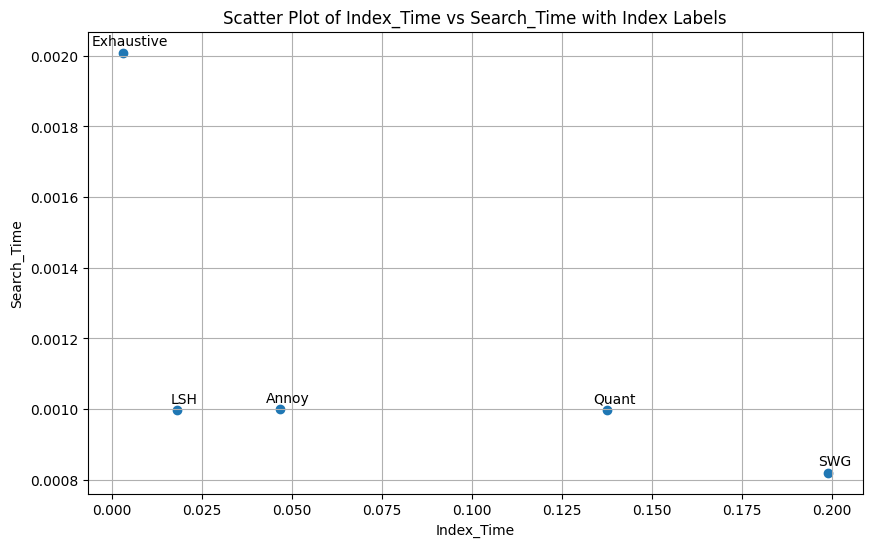

In [220]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
# df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8]}, index=['item1', 'item2', 'item3', 'item4'])

# Scatter plot of columns A vs B
plt.figure(figsize=(10, 6))
plt.scatter(df_NearNeigh['Index_Time'], df_NearNeigh['Search_Time'])

# Annotating each point with its index label
for idx, row in df_NearNeigh.iterrows():
    plt.annotate(idx, (row['Index_Time'], row['Search_Time']), textcoords="offset points", xytext=(5, 5), ha='center')

# Adding labels and title
plt.xlabel('Index_Time')
plt.ylabel('Search_Time')
plt.title('Scatter Plot of Index_Time vs Search_Time with Index Labels')

# Show plot
plt.grid()
plt.show()


In [221]:
import pandas as pd

# Example DataFrame
# df = pd.DataFrame({'ListColumn': [[1, 2, 3], [4, 5, 6], [7, 8, 9]]})
df = df_NearNeigh.copy()

# Expand the list column into separate columns
expanded_df = pd.DataFrame(df['Query_Results'].tolist(), index=df.index)

# Optionally, rename the new columns (e.g., Col_1, Col_2, ...)
expanded_df.columns = [f'Col_{i+1}' for i in range(expanded_df.shape[1])]

# Drop the original list column and concatenate the expanded columns
# df = df.drop('Query_Results', axis=1).join(expanded_df)
df = df.join(expanded_df)
# Display the resulting DataFrame
print(df.columns)

Index(['Query_Results', 'Index_Time', 'Search_Time', 'Col_1', 'Col_2', 'Col_3',
       'Col_4', 'Col_5', 'Col_6', 'Col_7', 'Col_8', 'Col_9', 'Col_10'],
      dtype='object')


In [222]:
df.columns

Index(['Query_Results', 'Index_Time', 'Search_Time', 'Col_1', 'Col_2', 'Col_3',
       'Col_4', 'Col_5', 'Col_6', 'Col_7', 'Col_8', 'Col_9', 'Col_10'],
      dtype='object')

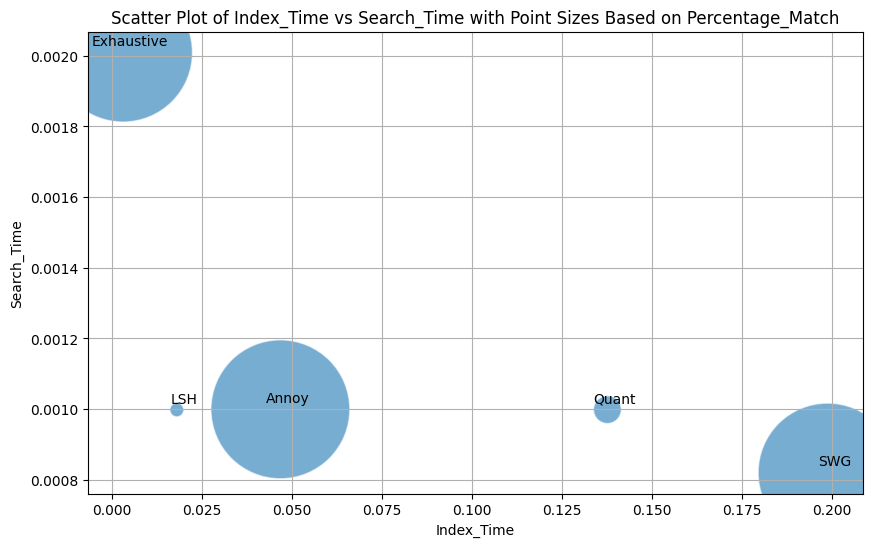

,Query_Results,Index_Time,Search_Time,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,Percentage_Match
NearNeigh_Type,,,,,,,,,,,,,,
Exhaustive,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.002994,0.002009,Toy Story (1995) 01-Jan-1995,"Goofy Movie, A (1995) 01-Jan-1995",Gumby: The Movie (1995) 01-Jan-1995,Kids (1995) 01-Jan-1995,Welcome to the Dollhouse (1995) 24-May-1996,"Little Princess, A (1995) 01-Jan-1995",Candyman: Farewell to the Flesh (1995) 01-Jan-...,Castle Freak (1995) 01-Jan-1995,Boys Life (1995) 01-Jan-1995,Friday (1995) 01-Jan-1995,100.0
Annoy,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.046731,0.000999,Toy Story (1995) 01-Jan-1995,"Goofy Movie, A (1995) 01-Jan-1995",Gumby: The Movie (1995) 01-Jan-1995,Kids (1995) 01-Jan-1995,Welcome to the Dollhouse (1995) 24-May-1996,"Little Princess, A (1995) 01-Jan-1995",Candyman: Farewell to the Flesh (1995) 01-Jan-...,Castle Freak (1995) 01-Jan-1995,Boys Life (1995) 01-Jan-1995,Friday (1995) 01-Jan-1995,100.0
LSH,"[Toy Story (1995) 01-Jan-1995, From Dusk Till ...",0.017951,0.000998,Toy Story (1995) 01-Jan-1995,From Dusk Till Dawn (1996) 05-Feb-1996,Hoop Dreams (1994) 01-Jan-1994,Faster Pussycat! Kill! Kill! (1965) 01-Jan-1965,"Aristocats, The (1970) 01-Jan-1970","Godfather, The (1972) 01-Jan-1972",Breakfast at Tiffany's (1961) 01-Jan-1961,Swingers (1996) 18-Oct-1996,Basic Instinct (1992) 01-Jan-1992,"Abyss, The (1989) 01-Jan-1989",10.0
Quant,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.137631,0.000998,Toy Story (1995) 01-Jan-1995,"Goofy Movie, A (1995) 01-Jan-1995",French Twist (Gazon maudit) (1995) 01-Jan-1995,In the Bleak Midwinter (1995) 23-Feb-1996,Target (1995) 28-Feb-1996,"Frighteners, The (1996) 19-Jul-1996",Strange Days (1995) 01-Jan-1995,Gumby: The Movie (1995) 01-Jan-1995,Castle Freak (1995) 01-Jan-1995,Wings of Courage (1995) 01-Jan-1995,20.0
SWG,"[Toy Story (1995) 01-Jan-1995, Goofy Movie, A ...",0.198826,0.000820,Toy Story (1995) 01-Jan-1995,"Goofy Movie, A (1995) 01-Jan-1995",Gumby: The Movie (1995) 01-Jan-1995,Kids (1995) 01-Jan-1995,Welcome to the Dollhouse (1995) 24-May-1996,"Little Princess, A (1995) 01-Jan-1995",Candyman: Farewell to the Flesh (1995) 01-Jan-...,Castle Freak (1995) 01-Jan-1995,Boys Life (1995) 01-Jan-1995,Friday (1995) 01-Jan-1995,100.0


In [241]:
# import pandas as pd

# # Example DataFrame
# df = pd.DataFrame({
#     'A': ['x', 'y', 'z', 'w'],
#     'B': [10, 20, 30, 40],
#     'Col_1': [1, 2, 1, 4],
#     'Col_2': [5, 6, 5, 8],
#     'Col_3': [9, 10, 9, 12],
#     'Col_4': [13, 14, 13, 16],
#     'Col_5': [17, 18, 17, 20],
#     'Col_6': [21, 22, 21, 24],
#     'Col_7': [25, 26, 25, 28],
#     'Col_8': [29, 30, 29, 32],
#     'Col_9': [33, 34, 33, 36],
#     'Col_10': [37, 38, 37, 40]
# })

# Get the values of the first row for columns Col_1 to Col_10
first_row = df.iloc[0][['Col_1', 'Col_2', 'Col_3', 'Col_4', 'Col_5', 
                        'Col_6', 'Col_7', 'Col_8', 'Col_9', 'Col_10']]

# Calculate the percentage match for each row compared to the first row
percentage_match = (df[['Col_1', 'Col_2', 'Col_3', 'Col_4', 'Col_5', 
                        'Col_6', 'Col_7', 'Col_8', 'Col_9', 'Col_10']] == first_row).mean(axis=1) * 100

# Add the percentage match as a new column in the DataFrame
df['Percentage_Match'] = percentage_match

plt.figure(figsize=(10, 6))
plt.scatter(df['Index_Time'], df['Search_Time'], s=percentage_match**2, alpha=0.6, edgecolors='w')

# Annotating each point with its index label
for idx, row in df.iterrows():
    plt.annotate(idx, (row['Index_Time'], row['Search_Time']), textcoords="offset points", xytext=(5, 5), ha='center')


# Adding labels and title
plt.xlabel('Index_Time')
plt.ylabel('Search_Time')
plt.title('Scatter Plot of Index_Time vs Search_Time with Point Sizes Based on Percentage_Match')

# Display the plot
plt.grid()
plt.show()
# Display the DataFrame
df


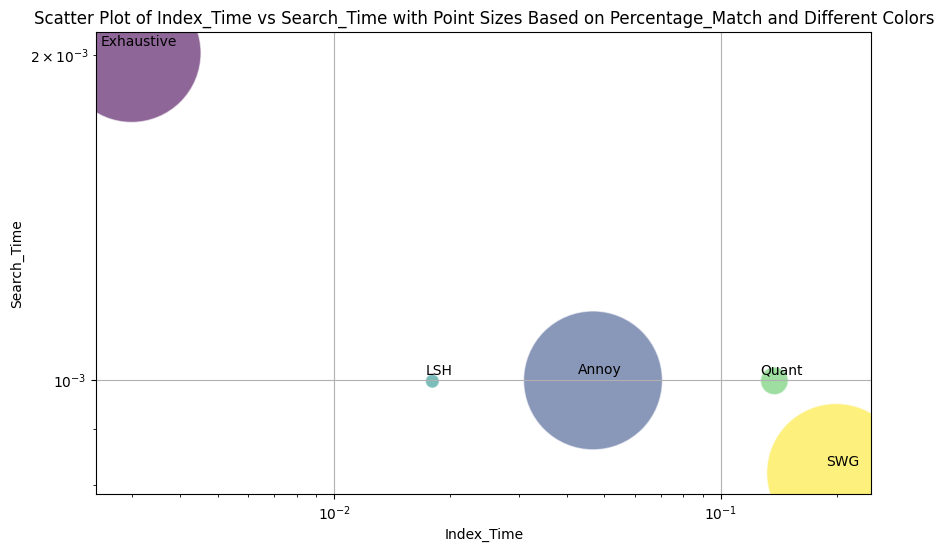

In [224]:
# # Generate a colormap
# colors = plt.cm.viridis(np.linspace(0, 1, len(df)))

# # Scatter plot of A vs B with point sizes based on Percentage_Match and different colors
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(df['Index_Time'], df['Search_Time'], s=percentage_match**2, c=colors, alpha=0.6, edgecolors='w')

# # Annotating each point with its index label
# for idx, row in df.iterrows():
#     plt.annotate(idx, (row['Index_Time'], row['Search_Time']), textcoords="offset points", xytext=(5, 5), ha='center')

# plt.yscale('log')
# plt.xscale('log')
# # Adding labels and title
# plt.xlabel('Index_Time')
# plt.ylabel('Search_Time')
# plt.title('Scatter Plot of Index_Time vs Search_Time with Point Sizes Based on Percentage_Match and Different Colors')

# # Display the plot
# plt.grid()
# plt.show()

In [236]:
df
df_sum = df[['Index_Time', 'Search_Time', 'Percentage_Match']].copy()
df_sum [['Index_Time', 'Search_Time']] = df_sum [['Index_Time', 'Search_Time']] * 1000
df_sum.rename (columns = {'Index_Time':'Index_Time(ms)','Search_Time':'Search_Time(ms)' }, inplace = True)
df_sum

,Index_Time(ms),Search_Time(ms),Percentage_Match
NearNeigh_Type,,,
Exhaustive,2.993822,2.008677,100.0
Annoy,46.731234,0.999212,100.0
LSH,17.951012,0.997543,10.0
Quant,137.631416,0.998259,20.0
SWG,198.825598,0.820160,100.0


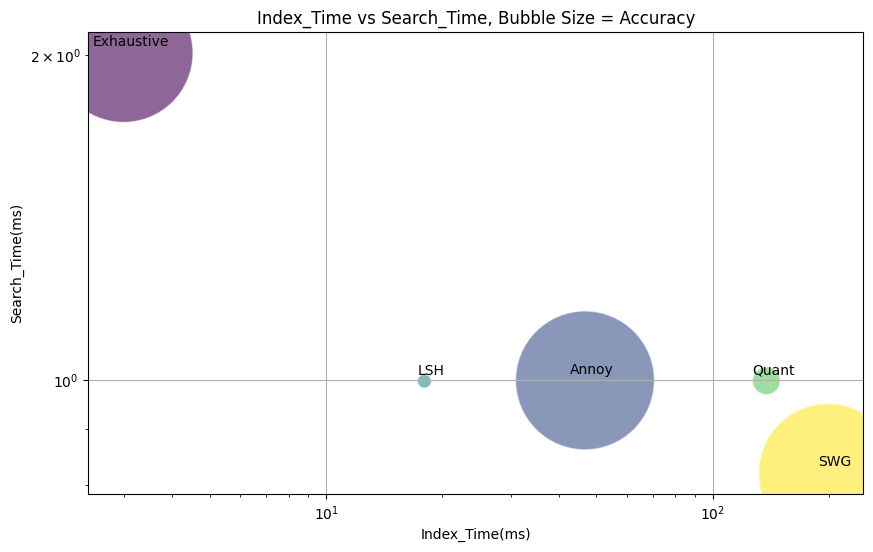

In [239]:
# Generate a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(df_sum)))

# Scatter plot of A vs B with point sizes based on Percentage_Match and different colors
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_sum['Index_Time(ms)'], df_sum['Search_Time(ms)'], s=percentage_match**2, c=colors, alpha=0.6, edgecolors='w')

# Annotating each point with its index label
for idx, row in df_sum.iterrows():
    plt.annotate(idx, (row['Index_Time(ms)'], row['Search_Time(ms)']), textcoords="offset points", xytext=(5, 5), ha='center')

plt.yscale('log')
plt.xscale('log')
# Adding labels and title
plt.xlabel('Index_Time(ms)')
plt.ylabel('Search_Time(ms)')
plt.title('Index_Time vs Search_Time, Bubble Size = Accuracy')

# Display the plot
plt.grid()
plt.show()